In [2]:
import numpy as np
from collections import Counter
import pandas as pd
from graphviz import Digraph
from io import BytesIO
from IPython.display import display
import matplotlib.pyplot as plt

# validation functions (accuracy and mse)

In [3]:
def accuracy_score(y, preds):
    correct = 0
    for i in range(len(y)):
        if y[i] == preds[i]:
            correct += 1
    return correct / float(len(y)) * 100.0

def mse(y, preds):
    sum_error = 0
    for i in range(len(y)):
        sum_error += (y[i] - preds[i])**2
    return sum_error

# initial classes

We’ll need two classes:

1. Node – implements a single node of a decision tree
2. DecisionTree – implements the algorithm




In [4]:
class Node:
    '''
    Helper class which implements a single tree node.
    '''
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value

In [5]:
class DecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self, min_samples_split=2, max_depth=5,criterion='entropy'):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        self.criterion=criterion

    @staticmethod
    def _entropy(s):
        '''
        Helper function, calculates entropy from an array of integer values.

        :param s: list
        :return: float, entropy value
        '''
        # Convert to integers to avoid runtime errors
        counts = np.bincount(np.array(s, dtype=np.int64))
        # Probabilities of each class label
        percentages = counts / len(s)

        # Caclulate entropy
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy

    def _gini(self,s):
       # Get the counts of each class
       class_counts = np.bincount(np.array(s, dtype=np.int64))
       percentages=class_counts/len(s)

       #calculate the Gini impurity
       gini=1-np.sum(percentages**2)
       return gini


    def _information_gain(self, parent, left_child, right_child):
        '''
        Helper function, calculates information gain from a parent and two child nodes.

        :param parent: list, the parent node
        :param left_child: list, left child of a parent
        :param right_child: list, right child of a parent
        :return: float, information gain
        '''
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)
        if self.criterion=='entropy':
          return self._entropy(parent) - (num_left * self._entropy(left_child) + num_right * self._entropy(right_child))

        elif self.criterion=='gini':
          return self._gini(parent) - (num_left * self._gini(left_child) + num_right * self._gini(right_child))

        else:
          raise ValueError("Invalid criterion. It should be either 'entropy' or 'gini'")





    def _best_split(self, X, y, used_features=None):
        '''
        Helper function, calculates the best split for given features and target

        :param X: np.array, features
        :param y: np.array or list, target
        :return: dict
        '''

        if used_features is None:
            used_features = set()
        best_split = {'gain': 0}
        best_info_gain = -1
        n_rows, n_cols = X.shape

        # For every dataset feature
        for f_idx in range(n_cols):
          if f_idx not in used_features:
            X_curr = X[:, f_idx]
            # For every unique value of that feature
            for threshold in np.unique(X_curr):
                #It creates a new dataset that includes both the features and the target, and split it to the left and right parts
                # Left part includes records lower or equal to the threshold
                # Right part includes records higher than the threshold
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[f_idx] <= threshold])
                df_right = np.array([row for row in df if row[f_idx] > threshold])

                # Do the calculation only if there's data in both subsets
                if len(df_left) > 0 and len(df_right) > 0:
                    # Obtain the value of the target variable for subsets
                    y = df[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]

                    # Caclulate the information gain
                    gain = self._information_gain(y, y_left, y_right)
                      #save the split parameters
                      # if the current split if better then the previous best
                    if gain > best_info_gain:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gain': gain
                        }
                        best_info_gain = gain
        return best_split
    def _build(self, X, y, depth=0, used_features=None):
        '''
        Helper recursive function, used to build a decision tree from the input data.

        :param X: np.array, features
        :param y: np.array or list, target
        :param depth: current depth of a tree, used as a stopping criteria
        :return: Node
        '''

        if used_features is None:
          used_features = set()
        n_rows, n_cols = X.shape

        # Check to see if a node should be leaf node
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            # Get the best split
            best = self._best_split(X, y, used_features)
            # If the split isn't pure
            if best['gain'] > 0:
                # Build a tree on the left
                left = self._build(
                    X=best['df_left'][:, :-1],
                    y=best['df_left'][:, -1],
                    depth=depth + 1,
                    used_features=used_features | {best['feature_index']}
                )
                right = self._build(
                    X=best['df_right'][:, :-1],
                    y=best['df_right'][:, -1],
                    depth=depth + 1,
                    used_features=used_features | {best['feature_index']}
                )
                return Node(
                    feature=best['feature_index'],
                    threshold=best['threshold'],
                    data_left=left,
                    data_right=right,
                    gain=best['gain']
                )
        # Leaf node - value is the most common target value
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )
    def fit(self, X, y):
        '''
        Function used to train a decision tree classifier model.

        :param X: np.array, features
        :param y: np.array or list, target
        :return: None
        '''
        # Call a recursive function to build the tree
        self.root = self._build(X, y)
    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).

        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''
        # Leaf node
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]

        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)

        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)

    def predict(self, X):
        '''
        Function used to classify new instances.

        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]

    # def print_tree(self,node,depth=0):
    #   if node is None:
    #     return
    #   prefix = "    " * depth
    # # If the node is a leaf node, print its value
    #   if node.value is not None:
    #     print(f"{prefix}Value: {node.value}")
    #   else:
    #     # Print the feature and threshold for the split at this node
    #     print(f"{prefix}Feature: {node.feature}, Threshold: {node.threshold}")
    #     # Recursively print the left and right subtrees
    #     print(f"{prefix}--> Left:")
    #     self.print_tree(node.data_left, depth + 1)
    #     print(f"{prefix}--> Right:")
    #     self.print_tree(node.data_right, depth + 1)

    def print_tree(self, node, features_name, dot=None):
        if dot is None:
            dot = Digraph()

        if node is None:
            return dot

        if node.value is not None:
            dot.node(str(id(node)), label=f"Value: {node.value}")
        else:
            dot.node(str(id(node)), label=f"Feature: {features_name[node.feature]},\nThreshold: {node.threshold}")
            if node.data_left:
                dot.edge(str(id(node)), str(id(node.data_left)), label="<")
                self.print_tree(node.data_left,features_name, dot)
            if node.data_right:
                dot.edge(str(id(node)), str(id(node.data_right)), label=">")
                self.print_tree(node.data_right, features_name, dot)

        return dot




# kfold cross validation

In [6]:
#kfold cross validation


def cross_validation(model, X, y, k=5):
    # Get the number of data samples
    n = len(X)

    # Shuffle the indices
    indices = np.arange(n) #creates an array of integers from 0 to n-1
    np.random.shuffle(indices)

    # Split the indices into k folds
    fold_sizes = np.full(k, n // k, dtype=int)
    fold_sizes[:n % k] += 1  # The first n % k folds have size n // k + 1
    current = 0
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        folds.append(indices[start:stop])
        current = stop

    # For each fold, train the model on the other folds and test it on this fold
    scores = []
    for i in range(k):
        train_indices = np.concatenate([folds[j] for j in range(k) if j != i])
        test_indices = folds[i]

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)

    return scores

# Usage:
# scores = cross_validation(model, X, y, k=5)
# print('Cross-validation scores:', scores)
# print('Mean accuracy:', np.mean(scores))


# split_train_test function

In [7]:
def split_train_test(X, y, test_size=0.2):
    # Determine the number of training examples
    num_train = int((1 - test_size) * len(X))

    # Shuffle the indices
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    # Split the indices
    train_indices = indices[:num_train]
    test_indices = indices[num_train:]

    # Split X and y
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test

# test the implemented decision tree class using iris dataset

In [8]:
from sklearn.datasets import load_iris

iris = load_iris()

X = iris['data']
y = iris['target']

In [9]:
X_train , X_test, y_train, y_test=split_train_test(X,y)

In [10]:
model = DecisionTree(criterion='gini')
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [11]:
print(accuracy_score(y_test, preds))

93.33333333333333


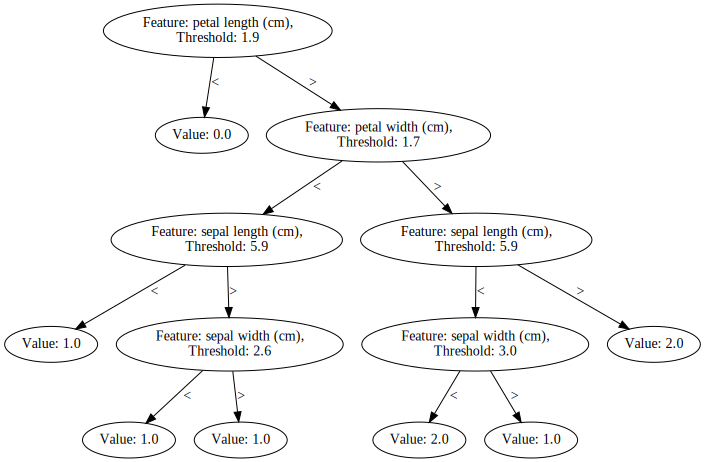

In [12]:
model.print_tree(model.root,features_name=iris.feature_names)

# load bank dataset

In [13]:
file_path="/content/drive/MyDrive/data.csv"
dataframe=pd.read_csv(file_path)
dataframe

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1001,999.0,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,1002,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,1003,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,1004,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,1005,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,46207,51.0,technician,married,tertiary,no,825.0,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,46208,71.0,retired,divorced,primary,no,1729.0,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,46209,72.0,retired,married,secondary,no,5715.0,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,46210,57.0,blue-collar,married,secondary,no,668.0,no,no,telephone,17,nov,508,4,-1,0,unknown,no


# data cleaning

In [14]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         45211 non-null  int64  
 1   age        45202 non-null  float64
 2   job        45211 non-null  object 
 3   marital    45211 non-null  object 
 4   education  45211 non-null  object 
 5   default    45211 non-null  object 
 6   balance    45208 non-null  float64
 7   housing    45211 non-null  object 
 8   loan       45211 non-null  object 
 9   contact    45211 non-null  object 
 10  day        45211 non-null  int64  
 11  month      45211 non-null  object 
 12  duration   45211 non-null  int64  
 13  campaign   45211 non-null  int64  
 14  pdays      45211 non-null  int64  
 15  previous   45211 non-null  int64  
 16  poutcome   45211 non-null  object 
 17  y          45211 non-null  object 
dtypes: float64(2), int64(6), object(10)
memory usage: 6.2+ MB


In [15]:
null_rows=dataframe[dataframe.isnull().any(axis=1)]
null_rows

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
7,1008,NaN,entrepreneur,divorced,tertiary,yes,NaN,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,1009,58.0,retired,married,primary,no,NaN,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,1010,43.0,technician,single,secondary,no,NaN,yes,no,unknown,5,may,55,1,-1,0,unknown,no
53,1054,NaN,admin.,single,secondary,no,-76.0,yes,no,unknown,5,may,787,1,-1,0,unknown,no
54,1055,NaN,technician,single,secondary,no,-103.0,yes,yes,unknown,5,may,145,1,-1,0,unknown,no
55,1056,NaN,entrepreneur,single,tertiary,no,243.0,no,yes,unknown,5,may,174,1,-1,0,unknown,no
56,1057,NaN,management,single,tertiary,no,424.0,yes,no,unknown,5,may,104,1,-1,0,unknown,no
57,1058,NaN,blue-collar,married,unknown,no,306.0,yes,no,unknown,5,may,13,1,-1,0,unknown,no
58,1059,NaN,blue-collar,single,unknown,no,24.0,yes,no,unknown,5,may,185,1,-1,0,unknown,no
59,1060,NaN,services,married,primary,no,179.0,yes,no,unknown,5,may,1778,1,-1,0,unknown,no


In [16]:
def unique_column(df):
  for column in df.columns:
    print(f"unique values of {column}: {df[column].unique()}\n")

In [17]:
unique_column(dataframe)

unique values of Id: [ 1001  1002  1003 ... 46209 46210 46211]

unique values of age: [999.  44.  33.  47.  35.  28.  nan  58.  43.  41.  29.  53.  57.  51.
  45.  60.  56.  32.  25.  40.  39.  52.  46.  36.  49.  59.  37.  50.
  54.  55.  48.  31.  42.  30.  27.  34.  38.  23.  26.  61.  22.  24.
  21.  20.  66.  62.  83.  75.  67.  70.  65.  68.  64.  69.  72.  71.
  19.  76.  85.  63.  90.  82.  73.  74.  78.  80.  94.  79.  77.  86.
  95.  81.  18.  89.  84.  87.  92.  93.  88.  -1.]

unique values of job: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

unique values of marital: ['married' 'single' 'divorced']

unique values of education: ['tertiary' 'secondary' 'unknown' 'primary']

unique values of default: ['no' 'yes']

unique values of balance: [2.1430e+03 2.9000e+01 2.0000e+00 ... 8.2050e+03 1.4204e+04 1.6353e+04]

unique values of housing: ['yes' 'no']

unique values of loan

Based on the above output we can see this anomalies:

*   age 999 and negative age like -1
*   unknown value in job column which means nan
* unknown in education
*unknown value in contact
*negative values in pdays
*unknown poutcome

In [18]:
unknown_job=dataframe[dataframe['job']=='unknown']
unknown_job

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4,1005,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198,1,-1,0,unknown,no
216,1217,47.0,unknown,married,unknown,no,28.0,no,no,unknown,5,may,338,2,-1,0,unknown,no
354,1355,59.0,unknown,divorced,unknown,no,27.0,no,no,unknown,5,may,347,3,-1,0,unknown,no
876,1877,37.0,unknown,single,unknown,no,414.0,yes,no,unknown,7,may,131,1,-1,0,unknown,no
1072,2073,29.0,unknown,single,primary,no,50.0,yes,no,unknown,7,may,50,2,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44714,45715,45.0,unknown,married,tertiary,no,406.0,no,no,cellular,7,sep,314,1,-1,0,unknown,yes
44742,45743,64.0,unknown,married,unknown,no,2799.0,no,no,telephone,9,sep,378,4,-1,0,unknown,no
44970,45971,28.0,unknown,single,unknown,no,326.0,no,no,cellular,11,oct,450,1,231,1,success,yes
45141,46142,77.0,unknown,married,unknown,no,397.0,no,no,telephone,8,nov,207,1,185,3,success,no


replace every unknown value in each column with np.nan

In [19]:
dataframe.replace('unknown', np.nan, inplace=True)

In [20]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         45211 non-null  int64  
 1   age        45202 non-null  float64
 2   job        44923 non-null  object 
 3   marital    45211 non-null  object 
 4   education  43354 non-null  object 
 5   default    45211 non-null  object 
 6   balance    45208 non-null  float64
 7   housing    45211 non-null  object 
 8   loan       45211 non-null  object 
 9   contact    32191 non-null  object 
 10  day        45211 non-null  int64  
 11  month      45211 non-null  object 
 12  duration   45211 non-null  int64  
 13  campaign   45211 non-null  int64  
 14  pdays      45211 non-null  int64  
 15  previous   45211 non-null  int64  
 16  poutcome   8252 non-null   object 
 17  y          45211 non-null  object 
dtypes: float64(2), int64(6), object(10)
memory usage: 6.2+ MB


show all rows with at least one NaN value in it

In [21]:
null_rows=dataframe[dataframe.isnull().any(axis=1)]
null_rows

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1001,999.0,management,married,tertiary,no,2143.0,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,1002,44.0,technician,single,secondary,no,29.0,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,1003,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,1004,47.0,blue-collar,married,NaN,no,1506.0,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,1005,33.0,NaN,single,NaN,no,1.0,no,no,NaN,5,may,198,1,-1,0,NaN,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45203,46204,-1.0,student,single,tertiary,no,113.0,no,no,cellular,17,nov,266,1,-1,0,NaN,yes
45205,46206,-1.0,technician,single,secondary,no,505.0,no,yes,cellular,17,nov,386,2,-1,0,NaN,yes
45206,46207,51.0,technician,married,tertiary,no,825.0,no,no,cellular,17,nov,977,3,-1,0,NaN,yes
45207,46208,71.0,retired,divorced,primary,no,1729.0,no,no,cellular,17,nov,456,2,-1,0,NaN,yes


poutcome and contact columns have so many nan values and they dont have any considerable effect on our prediction. so we delete this columns from each entry of our dataset.
why?


poutcome shows was marketing campaign successful for this customer or not?

and contact shows whith which we connect to our customer?

In [22]:
# delete contact and poutcome columns
columns_to_drop = ['contact', 'poutcome']
dataframe.drop([col for col in columns_to_drop if col in dataframe.columns], axis=1, inplace=True)

Still we have 2027 columns which have NaN vaues which is too much!!!

In [23]:
null_rows=dataframe[dataframe.isnull().any(axis=1)]
null_rows

,Id,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
3,1004,47.0,blue-collar,married,NaN,no,1506.0,yes,no,5,may,92,1,-1,0,no
4,1005,33.0,NaN,single,NaN,no,1.0,no,no,5,may,198,1,-1,0,no
7,1008,NaN,entrepreneur,divorced,tertiary,yes,NaN,yes,no,5,may,380,1,-1,0,no
8,1009,58.0,retired,married,primary,no,NaN,yes,no,5,may,50,1,-1,0,no
9,1010,43.0,technician,single,secondary,no,NaN,yes,no,5,may,55,1,-1,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45129,46130,46.0,technician,married,NaN,no,3308.0,no,no,27,oct,171,1,91,2,yes
45141,46142,77.0,NaN,married,NaN,no,397.0,no,no,8,nov,207,1,185,3,no
45150,46151,65.0,management,married,NaN,no,2352.0,no,no,8,nov,354,3,188,13,no
45158,46159,34.0,student,single,NaN,no,2321.0,no,no,9,nov,600,2,99,5,no


Let's see which columns have the most effect of this number of NaN values??!

In [24]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         45211 non-null  int64  
 1   age        45202 non-null  float64
 2   job        44923 non-null  object 
 3   marital    45211 non-null  object 
 4   education  43354 non-null  object 
 5   default    45211 non-null  object 
 6   balance    45208 non-null  float64
 7   housing    45211 non-null  object 
 8   loan       45211 non-null  object 
 9   day        45211 non-null  int64  
 10  month      45211 non-null  object 
 11  duration   45211 non-null  int64  
 12  campaign   45211 non-null  int64  
 13  pdays      45211 non-null  int64  
 14  previous   45211 non-null  int64  
 15  y          45211 non-null  object 
dtypes: float64(2), int64(6), object(8)
memory usage: 5.5+ MB


In [25]:
dataframe.dropna(inplace=True)

In [26]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43184 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         43184 non-null  int64  
 1   age        43184 non-null  float64
 2   job        43184 non-null  object 
 3   marital    43184 non-null  object 
 4   education  43184 non-null  object 
 5   default    43184 non-null  object 
 6   balance    43184 non-null  float64
 7   housing    43184 non-null  object 
 8   loan       43184 non-null  object 
 9   day        43184 non-null  int64  
 10  month      43184 non-null  object 
 11  duration   43184 non-null  int64  
 12  campaign   43184 non-null  int64  
 13  pdays      43184 non-null  int64  
 14  previous   43184 non-null  int64  
 15  y          43184 non-null  object 
dtypes: float64(2), int64(6), object(8)
memory usage: 5.6+ MB


In [27]:
unique_column(dataframe)

unique values of Id: [ 1001  1002  1003 ... 46209 46210 46211]

unique values of age: [999.  44.  33.  35.  28.  41.  29.  53.  57.  51.  60.  56.  32.  25.
  40.  39.  52.  46.  36.  49.  59.  37.  50.  54.  58.  55.  48.  31.
  43.  45.  47.  42.  30.  27.  34.  38.  23.  26.  61.  22.  24.  21.
  20.  66.  62.  83.  75.  67.  70.  65.  68.  64.  69.  72.  71.  76.
  85.  63.  90.  82.  73.  74.  78.  80.  94.  79.  19.  77.  86.  95.
  81.  18.  89.  84.  87.  88.  -1.]

unique values of job: ['management' 'technician' 'entrepreneur' 'admin.' 'services' 'retired'
 'blue-collar' 'self-employed' 'unemployed' 'housemaid' 'student']

unique values of marital: ['married' 'single' 'divorced']

unique values of education: ['tertiary' 'secondary' 'primary']

unique values of default: ['no' 'yes']

unique values of balance: [2.1430e+03 2.9000e+01 2.0000e+00 ... 8.2050e+03 1.4204e+04 1.6353e+04]

unique values of housing: ['yes' 'no']

unique values of loan: ['no' 'yes']

unique values of day

In [28]:
columns_to_convert = ['default', 'housing','loan','y']
for col in columns_to_convert:
    if col in dataframe.columns:
        dataframe[col] = dataframe[col].replace({'yes': 1, 'no': 0})


In [29]:
dataframe.drop(dataframe[(dataframe['age'] < 0) | (dataframe['age'] > 100)].index, inplace=True)

In [30]:
dataframe['age'].unique()

array([44., 33., 35., 28., 41., 29., 53., 57., 51., 60., 56., 32., 25.,
       40., 39., 52., 46., 36., 49., 59., 37., 50., 54., 58., 55., 48.,
       31., 43., 45., 47., 42., 30., 27., 34., 38., 23., 26., 61., 22.,
       24., 21., 20., 66., 62., 83., 75., 67., 70., 65., 68., 64., 69.,
       72., 71., 76., 85., 63., 90., 82., 73., 74., 78., 80., 94., 79.,
       19., 77., 86., 95., 81., 18., 89., 84., 87., 88.])

In [31]:
dataframe=pd.get_dummies(dataframe,columns=['job','marital'])

In [32]:
unique_column(dataframe)

unique values of Id: [ 1002  1003  1006 ... 46209 46210 46211]

unique values of age: [44. 33. 35. 28. 41. 29. 53. 57. 51. 60. 56. 32. 25. 40. 39. 52. 46. 36.
 49. 59. 37. 50. 54. 58. 55. 48. 31. 43. 45. 47. 42. 30. 27. 34. 38. 23.
 26. 61. 22. 24. 21. 20. 66. 62. 83. 75. 67. 70. 65. 68. 64. 69. 72. 71.
 76. 85. 63. 90. 82. 73. 74. 78. 80. 94. 79. 19. 77. 86. 95. 81. 18. 89.
 84. 87. 88.]

unique values of education: ['secondary' 'tertiary' 'primary']

unique values of default: [0 1]

unique values of balance: [2.9000e+01 2.0000e+00 2.3100e+02 ... 8.2050e+03 1.4204e+04 1.6353e+04]

unique values of housing: [1 0]

unique values of loan: [0 1]

unique values of day: [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]

unique values of month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

unique values of duration: [ 151   76  139 ... 1298 1246 1556]

unique values of campaign: [ 1  2  3  5  4  7  8  6  9 10 11 12 13

pdays column in the bank dataset stands for previous days. it represents the number of days that passed by after the client was last contacted from previous campaign. so it dont have to be negative

In [33]:
dataframe.drop(dataframe[(dataframe['pdays'] < 0)].index, inplace=True)

In [34]:
dataframe['education']=dataframe['education'].replace({'secondary':2,'tertiary':3,'primary':1})

In [35]:
# Label Encoding
dataframe['month'] = dataframe['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})

In [36]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7911 entries, 24060 to 45210
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 7911 non-null   int64  
 1   age                7911 non-null   float64
 2   education          7911 non-null   int64  
 3   default            7911 non-null   int64  
 4   balance            7911 non-null   float64
 5   housing            7911 non-null   int64  
 6   loan               7911 non-null   int64  
 7   day                7911 non-null   int64  
 8   month              7911 non-null   int64  
 9   duration           7911 non-null   int64  
 10  campaign           7911 non-null   int64  
 11  pdays              7911 non-null   int64  
 12  previous           7911 non-null   int64  
 13  y                  7911 non-null   int64  
 14  job_admin.         7911 non-null   uint8  
 15  job_blue-collar    7911 non-null   uint8  
 16  job_entrepreneur   

In [37]:
dataframe.drop('Id', axis=1, inplace=True)

In [38]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7911 entries, 24060 to 45210
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                7911 non-null   float64
 1   education          7911 non-null   int64  
 2   default            7911 non-null   int64  
 3   balance            7911 non-null   float64
 4   housing            7911 non-null   int64  
 5   loan               7911 non-null   int64  
 6   day                7911 non-null   int64  
 7   month              7911 non-null   int64  
 8   duration           7911 non-null   int64  
 9   campaign           7911 non-null   int64  
 10  pdays              7911 non-null   int64  
 11  previous           7911 non-null   int64  
 12  y                  7911 non-null   int64  
 13  job_admin.         7911 non-null   uint8  
 14  job_blue-collar    7911 non-null   uint8  
 15  job_entrepreneur   7911 non-null   uint8  
 16  job_housemaid      

# Initially, we used ready-made classes for data classification to e

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier



# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree classifier and fit it to the training data
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [40]:
# Calculate accuracy on the test set
accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")


Accuracy: 100.00%


# classifying costumers using our implemented decisiontree class criterion='entropy'

In [46]:
# Assuming df is your DataFrame and 'target' is your target variable
X = dataframe.drop(['y'], axis=1)
y = dataframe['y']
column_names=X.columns.tolist()
X=X.values
y=y.values
X_train , X_test, y_train, y_test=split_train_test(X,y)
model = DecisionTree()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print('accuracy: ',accuracy_score(y_test, preds))
print('mse: ',mse(y_test,preds))

accuracy:  82.122552116235
mse:  283.0


**print the tree**

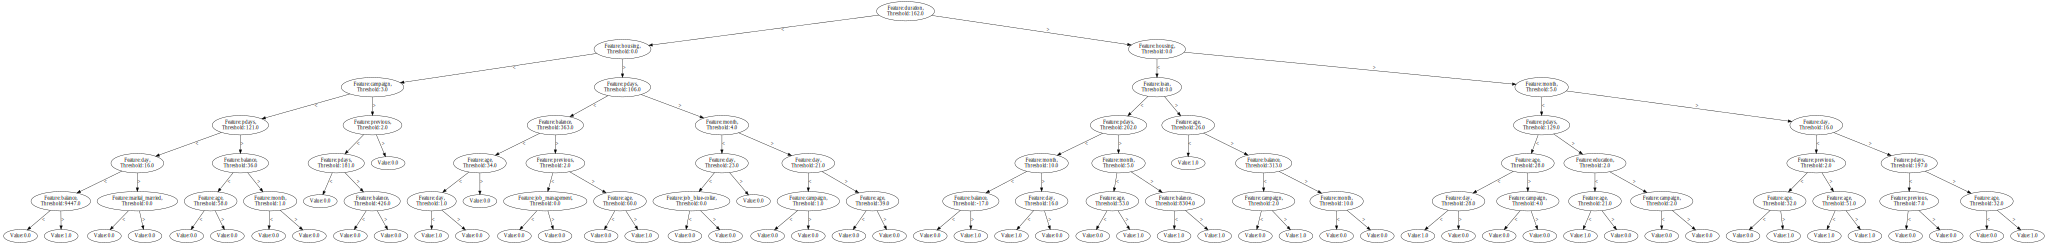

In [47]:
model.print_tree(model.root,features_name=column_names)

# using cross validation (criterion='entropy')

In [48]:
scores=cross_validation(model,X,y)
print('Cross validation scores:',scores)
print("Mean accuracy:",np.mean(scores))

Cross validation scores: [82.05938092229943, 81.47914032869785, 81.09987357774968, 81.98482932996207, 81.73198482932996]
Mean accuracy: 81.6710417976078


# classifying costumers using our implemented decisiontree class criterion='gini'

In [43]:
# Assuming df is your DataFrame and 'target' is your target variable
X = dataframe.drop('y', axis=1)
y = dataframe['y']
column_names=X.columns.tolist()
X=X.values
y=y.values
X_train , X_test, y_train, y_test=split_train_test(X,y)
model = DecisionTree(criterion='gini')
model.fit(X_train, y_train)
preds = model.predict(X_test)
print('accuracy: ',accuracy_score(y_test, preds))
print('mse: ',mse(y_test,preds))

accuracy:  80.85912823752369
mse:  303.0


**print the tree**

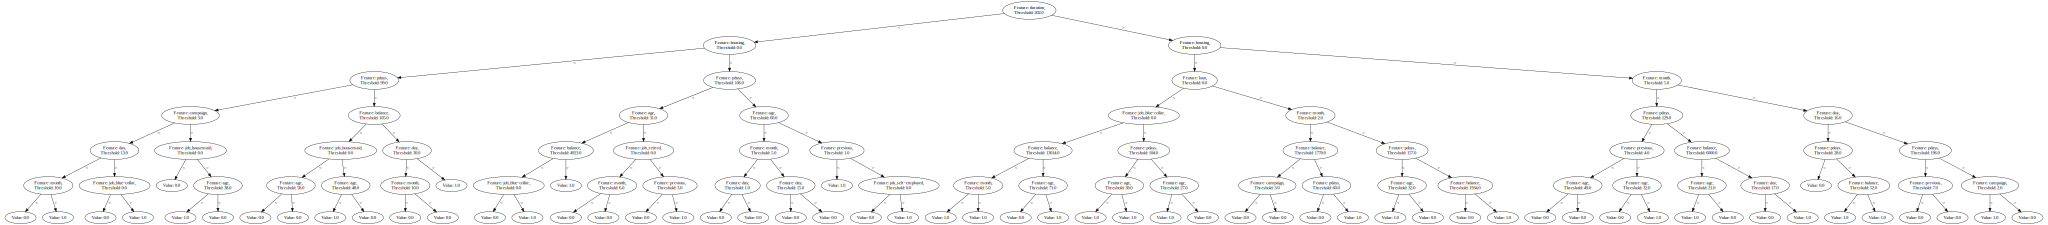

In [44]:
model.print_tree(model.root, features_name=column_names)

# cross validation (k=5 and criterion='gini'

In [45]:
scores=cross_validation(model,X,y)
print('Cross validation scores:',scores)
print("Mean accuracy:",np.mean(scores))

Cross validation scores: [80.79595704358813, 81.98482932996207, 83.24905183312264, 81.09987357774968, 82.7433628318584]
Mean accuracy: 81.97461492325618
